This notebook is being used to build the part of the cookbook that will perform the analyses. This will be merged in the future once all parts of the cookbook are complete. 

## Import packages

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
import sys
import urllib3
import json

import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list(). In order to access a specific data set,
import a CPTAC subfolder using either 'import CPTAC.Dataset' or 'from
CPTAC import Dataset'.
******
Version: 0.2.5
******
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


## Edit desired variables

In [2]:
'''Mutated gene of interest'''
gene = 'PIK3CA'

'''Database of interest'''
database = 'Endometrial'

'''Select which dataframes you want to analyze '''
proteomics = True
phosphoproteomics = True
transcriptomics = True
sub_type = True

## Get the dataframes

In [3]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

## General gene statistics

<b> Please enter the filename of your HotSpot 3D output (in excel form) </b>

In [9]:
filename = '../HotSpot3D_Output/HotSpot3DOutput.xlsx'

<b> Convert the HotSpot3D output to a dataframe </b>

In [11]:
hotspot_data = pd.ExcelFile('../HotSpot3D_Output/HotSpot3DOutput.xlsx')

<b> Get the sheet name called 'Clusters' to find the protein hotspot </b>

In [12]:
clusters = hotspot_data.parse('Clusters')

<b> Get the list of mutations in the hotspot </b>

In [13]:
try:
    '''Check if the gene of interest has a hotspot'''
    hotspot_areas = clusters.loc[clusters['Gene/Drug'] == gene]
    hotspot_mutations = hotspot_areas['Mutation/Gene']
    hotspot_mutations = hotspot_mutations.tolist()
    print(hotspot_mutations)
except:
    print('{}' '{}'.format(gene, ' does not have a hotspot in our data.'))
    hotspot = False


    


['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']


<b> Get all the patients who have mutations at these locations in the hotspot </b>

In [14]:
'''A list of mutations present in the hotspot according to our Hotspot3D output'''
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']
print('Patients with hotspot mutations: \n')
print(hotspot_patients)

#Convert to a list for further statistical analysis
hotspot_patients = hotspot_patients.tolist()

Patients with hotspot mutations: 

160      S001
1147     S003
1357     S009
4630     S021
16486    S023
19061    S024
21259    S032
21516    S033
22497    S038
37421    S061
38155    S063
39522    S066
43391    S067
43490    S068
46662    S084
47360    S088
47857    S090
49362    S097
49475    S098
Name: Clinical_Patient_Key, dtype: object


### Calculate Mutation Frequency

Total number of patients with PIK3CA mutations: 46
Total number of instances of PIK3CA mutation: 62

                   Mutation Count
Missense_Mutation              58
In_Frame_Del                    3
Frame_Shift_Ins                 1


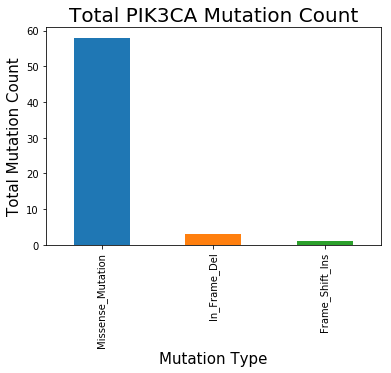

In [5]:
'''Get the data for mutated patients'''
gene_mutated = somatic.loc[somatic['Gene'] == gene]


'''This naturally includes a value that is 'NA' so we subtract 1'''
num_mutated = len(set(gene_mutated['Clinical_Patient_Key'])) - 1

'''Some people have more than one mutation so we need to grab the unique values'''
print('{}' '{}' '{}' '{}' .format('Total number of patients with ' , gene, ' mutations: ', num_mutated))
total_mutations = len(gene_mutated)
print('{}' '{}' '{}' '{}' '{}'.format('Total number of instances of ' , gene, ' mutation: ', total_mutations, '\n'))

'''Count the number of instances of various mutation types in the column 'Mutation' in the gene_mutated dataframe.'''
mut_counts = gene_mutated['Mutation'].value_counts()

'''The previous function returns a series. Convert the series to a dataframe'''
counts_df = mut_counts.to_frame()

'''Rename the column to clarify the number of mutations'''
counts_df = counts_df.rename(index=str, columns = { 'Mutation' : 'Mutation Count'})
print(counts_df)

'''Plot the frequencies'''
fig = mut_counts.plot.bar()
fig.set_title('{}' '{}' '{}'.format('Total ', gene, ' Mutation Count'), size = 20)
fig.set_ylabel('Total Mutation Count', size = 15)
fig.set_xlabel('Mutation Type', size = 15)
plt.show()

### Hotspot Mutation Frequency

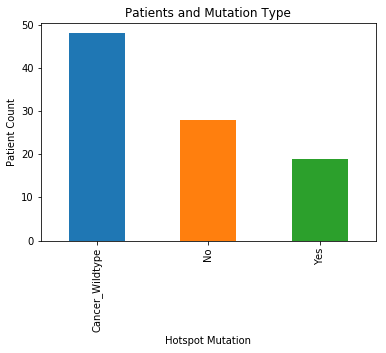

In [6]:
all_mutations = somatic['Clinical_Patient_Key']

all_patients = []
'''Get all the unique paitients in the somatic mutation data '''
for name in all_mutations:
    if name not in all_patients:
        all_patients.append(name)

'''Get the data for mutated patients'''
gene_mutated = somatic.loc[somatic['Gene'] == gene]


'''Get all the unique patients in the mutation list '''
mutated_patients = []

for name in gene_mutated['Clinical_Patient_Key']:
    if name not in mutated_patients:
        mutated_patients.append(name)

hotspot_indices = []      
for i in range(0, len(mutated_patients)):
    if mutated_patients[i] in hotspot_patients:
        hotspot_indices.append(i)

mutated_indices = []
for i in range(0, len(mutated_patients)):
    mutated_indices.append(i)
        

patients_df = pd.DataFrame()
patients_df['Patient_ID'] = all_patients

patients_df['Hotspot_Mutation'] = 'Cancer_Wildtype'

patients_df.loc[mutated_indices, 'Hotspot_Mutation'] = 'No'

patients_df.loc[hotspot_indices, 'Hotspot_Mutation'] = 'Yes'


patient_counts = patients_df['Hotspot_Mutation'].value_counts()
fig = patient_counts.plot.bar()
fig.set_title('Patients and Mutation Type')
fig.set_ylabel('Patient Count')
fig.set_xlabel('Hotspot Mutation')
plt.show()

## Playing with dataframes to format uniform dataframe for analysis

In [8]:
# play around with proteoimcs data

df = CPTAC.get_proteomics()
gene = 'PIK3CA'
category = 'Mutation'

cis = False
trans = True

prot_list = ['AKT1', 'TP53', 'AKT2']

#clinical variables will have to be processed differently than mutation. For clinical, use 'compare_clinical' and for mutation, used 'compare_mutation

big_df = pd.Dataframe()

for protein in prot_list:
    df_analysis = CPTAC.compare_mutations(df, protein, gene)
    print(df_analysis)







      AKT1_omics    PIK3CA_Mutation PIK3CA_Sample_Status
S001    -0.25500  Missense_Mutation                Tumor
S002     0.04530     Wildtype_Tumor                Tumor
S003    -0.07220  Missense_Mutation                Tumor
S005     0.09680     Wildtype_Tumor                Tumor
S006    -0.64100     Wildtype_Tumor                Tumor
S007    -0.41900     Wildtype_Tumor                Tumor
S008     0.14300     Wildtype_Tumor                Tumor
S009    -0.72500  Missense_Mutation                Tumor
S010    -0.09480  Missense_Mutation                Tumor
S011    -0.05910     Wildtype_Tumor                Tumor
S012    -0.34800  Missense_Mutation                Tumor
S014    -0.29100  Missense_Mutation                Tumor
S016    -0.69900     Wildtype_Tumor                Tumor
S017    -0.16200     Wildtype_Tumor                Tumor
S018     0.08090  Missense_Mutation                Tumor
S019    -0.09330     Wildtype_Tumor                Tumor
S020     0.25700     Wildtype_T

KeyError: 1

In [ ]:
def analyze_data(df, variable, cat1, cat2, protein):
    
    '''Create a list of the column names''' 
    col_names = df.columns()
    
    '''Remove the two categorical columns that do not include continuous variables'''
    col_names.remove('{}' '{}'.format(protein, '_Mutation'))
    col_names.remove('{}' '{}'.format(protein, '_Sample_Status'))
    
    '''Create two dictionaries to store significant and unsignificant results'''
    sigResults = {}
    nonsigResults = {}
    
    '''Separate the main dataframe into two separate dataframes by the selected categories'''
    df_1 = df.loc[df[variable] == cat1]
    df_2 = df.loc[df[variable] == cat2]
    
    '''Create lists for test statistics and the corresponding p-values'''
    tstats = []
    pvals = []
    
    '''Parse through each column and perform a ttest comparing the two selected categories'''
    for i in range(0, len(col_names)):
        #if col != '{}' '{}'.format(protein, '_Mutation') | col != '{}' '{}'.format(protein, '_Sample_Status'):
        tstat, pvalue = scipy.stats.ttest_ind(df_1[col_names[i]], df_2[col_names[i]])

        '''Append the results to the lists'''
        tstats.append(tstats)
        pvals.append(pvalue)
    
    
    '''Use a Bonferroni correction to filter significant results'''
    alpha = 0.05
    bonf_correction = alpha/len(pvals)
    
    '''Loop through the p-values to find those that are below the p-value cutoff (Bonferroni correction)'''
    for i in range(0, len(pvals)):
        if pvals[i] < bonf_correction:
            sigResults[col_names[i]] = pvals[i]
        else:
            nonsigResults[col_names[i]] = pvals[i]
            
    '''**** ~~~~ Put in the plots!!! *** ~~~'''
            
    return sigResults, nonsigResults
    
    
        
    
    